In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import time
np.random.seed(42)

# Comparacion modelos

## Carga de datos y preprocesamiento

In [2]:
!ls ./input

input_modelo_factores_1.csv		  input_poblacion_vina.csv
input_modelo_factores_2.csv		  input_salud_aleatoria_valpo_vina.csv
input_poblacion_aleatoria_valpo_vina.csv  input_salud_aleatoria_vina.csv
input_poblacion_aleatoria_vina.csv	  input_salud_blobs_valpo_vina.csv
input_poblacion_blobs_valpo_vina.csv	  input_salud_blobs_vina.csv
input_poblacion_blobs_vina.csv		  input_salud_valpo_vina.csv
input_poblacion_valpo_vina.csv		  input_salud_vina.csv


In [3]:
muestra = 'valpo_vina'
poblacion = pd.read_csv('input/input_poblacion_{}.csv'.format(muestra))
salud = pd.read_csv('input/input_salud_{}.csv'.format(muestra))
factores = pd.read_csv('input/input_modelo_factores_1.csv')

In [4]:
# Calculamos la demanda ponderada por cuada hacia cada tipo de centro de salud
edades = poblacion[['Edad<5', 'Edad5-14', 'Edad15-64', 'Edad>64']].to_numpy()
fac = factores[['Edad<5', 'Edad5-14', 'Edad15-64', 'Edad>64']].to_numpy()
demanda = edades.dot(fac.T)
# Agregar un factor de distancia muy alto a los centros no instalados
demanda = np.hstack([(np.zeros((len(edades),1))+999999),demanda])
demanda.shape

(7203, 4)

In [5]:
# Calculamos la distancia entre las manzanas y los centros de salud
pos_manzanas = poblacion[['x','y']].to_numpy()
pos_salud = salud[['x','y']].to_numpy()
# Calcular la distancia L1 
distancias = np.linalg.norm(pos_manzanas[:, np.newaxis, :] - pos_salud[np.newaxis, :, :], ord=1, axis=2)
distancias.shape

(7203, 76)

## Parametros del problema

In [6]:
presupuesto_inicial = 250
#        N,  H,  R,  U
costo = [0, 100, 25, 40] # Estimado en millones de dolares

In [7]:
# Funcion greedy de asignacion, asigna cada manzana al centro abierto mas cercano
def asignation(supplys_types, distances, ages_demand):
    weighted_dist = distances * ages_demand[:, supplys_types]
    asig = np.nanargmin(weighted_dist, axis=1)
    sol_cost = np.sum(np.take_along_axis(weighted_dist, asig[:, np.newaxis], axis=1))
    return asig, sol_cost

# Funcion objetivo, entrega la suma de distancias ponderada entre los centros asignados
def score_func(new_types, fixed_types, distances, ages_demand):
    supplys_types = np.hstack((fixed_types,new_types))
    asig, sol_cost = asignation(supplys_types, distances, ages_demand)
    return sol_cost, asig

## Algoritmo Greedy

In [8]:
def greedy(poblacion, salud, demanda, distancias, costo, presupuesto):
    dic = {'Por Definir':0, 'Hospital':1, 'Rutinario':2,'Urgencias':3}
    centros_fijos = np.array([dic[tipo] for tipo in salud[salud.Tipo != 'Por Definir'].Tipo])
    centros_nuevos = np.array([dic[tipo] for tipo in salud[salud.Tipo == 'Por Definir'].Tipo])
    presupuesto_inicial = presupuesto
    presupuesto = presupuesto
    mejor_solucion = centros_nuevos
    tiempo_inicio = time.time()
    sol_base, asig = score_func(centros_nuevos, centros_fijos, distancias, demanda)
    mejor_score = sol_base
    while presupuesto > np.min(costo[1:]):
        centros_nuevos = mejor_solucion.copy()
        mejor_mejora = 0
        mejor_centro = [0,0]
        for j in range(len(centros_nuevos)):
            if centros_nuevos[j] > 0:
                continue
            for k in range(1,4):
                centros_nuevos[j] = k
                nuevo_score, asig = score_func(centros_nuevos, centros_fijos, distancias, demanda)
                mejora = (mejor_score-nuevo_score)*costo[k]/presupuesto_inicial
                if mejora > mejor_mejora and np.sum([costo[i] for i in centros_nuevos])<presupuesto_inicial:
                    mejor_mejora = mejora
                    mejor_centro = [j,k]
                    mejor_score = nuevo_score
            centros_nuevos[j] = 0
        mejor_solucion[mejor_centro[0]] = mejor_centro[1]
        presupuesto-= costo[mejor_centro[1]]
    tiempo_final = time.time()-tiempo_inicio
    return tiempo_final, mejor_solucion, mejor_score

In [9]:
# tiempo, solucion, score = greedy(poblacion, salud, demanda, distancias, costo, presupuesto_inicial)
# print(tiempo, solucion, score)

## Algoritmo Genetico

In [10]:
#### Se define la poblacion de opciones, donde cada individuo representa una posible 
# posicion de cada establecimiento, siendo 1 a 3 cada tipo y 0 ninguno
def create_population(n_individuals, n_new_supply, supply_types):
    return np.random.randint(0, supply_types, (n_individuals,n_new_supply))

# Funcion que asigna cada nodo de demanda al establecimiento con menor costo por distancia
# Considerando el costo por cada tipo de los fijos y los nuevos, ademas entrega el costo de la solucion
def asignation(supplys_types, distances, ages_demand):
    weighted_dists = distances * ages_demand[:, supplys_types]
    asig = np.nanargmin(weighted_dists, axis=1)
    sol_cost = np.sum(np.take_along_axis(weighted_dists, asig[:, np.newaxis], axis=1))
    return asig, sol_cost

# Penalizacion por superar el presupuesto, este depende de cuan pasado esta y un factor de penalizacion
def penalization(individual, budget, supply_price, penalizations):
    expense = sum([supply_price[i] for i in individual])
    return expense*penalizations if expense>budget else 0

# Valor a minimizar, considera la suma de costos y la penalizacion
def score_genetic(individual, fixed_types, distance, ages_demand, budget, supply_price, penalizations):
    supplys_types = np.hstack((fixed_types,individual))
    asig, sol_cost = asignation(supplys_types, distance, ages_demand)
    return (sol_cost + penalization(individual, budget, supply_price, penalizations))

# Funcion de seleccion, elige los n mejores individuos 
def selection(population, scores, n_selected):
    selected = []
    for i in np.argsort(scores)[:n_selected]:
        selected.append(population[i])
    return selected

# Selecciona 2 de los mejores individuos y los mezcla para crear uno nuevo
def reproduction(population, selected):
    for i in range(population.shape[0]):
        fathers = np.random.randint(0, len(selected), 2)        
        point = np.random.randint(1, population.shape[1] - 1)
        population[i][:point] = selected[fathers[0]][:point]
        population[i][point:] = selected[fathers[1]][point:]
    return population

# Aleatoriamente un gen de cada individuo cambia
# esto varia si se instala o no un establecimiento y su tipo
def mutation(population, supply_types, mutation_rate):
    for individual in population:
        for i in range(len(individual)):
            if np.random.uniform(0,1)<=mutation_rate:
                individual[i] = np.random.randint(0,supply_types)
    return population

def run(supply_types, n_new_supply, fixed_types, distance, ages_demand, supply_price, budget,
    penalizations = 30000, mutation_rate = 0.2, n_individuals = 120, n_selected = 5, n_generations = 80):
    population = create_population(n_individuals, n_new_supply, supply_types)
    best_score = np.inf
    mean_scores = []
    c = 0
    for i in range(n_generations):
        scores = [score_genetic(individual, fixed_types, distance, ages_demand, budget, 
                        supply_price, penalizations) for individual in population]
        best = np.argmin(scores)
        mean_scores.append(scores[best])
        if scores[best] < best_score:
            c = 0
            best_sol = population[best].copy()
            best_score = scores[best]
        if c > 10:
            break
        selected = selection(population, scores, n_selected)
        population = reproduction(population, selected)
        population = mutation(population, supply_types, mutation_rate)
        c+=1
    return best_sol, mean_scores, best_score

def genetic(poblacion, salud, demanda, distancias, costo, presupuesto):
    dic = {'Por Definir':0, 'Hospital':1, 'Rutinario':2,'Urgencias':3}
    centros_fijos = np.array([dic[tipo] for tipo in salud[salud.Tipo != 'Por Definir'].Tipo])
    centros_nuevos = np.array([dic[tipo] for tipo in salud[salud.Tipo == 'Por Definir'].Tipo])
    supply_types = demanda.shape[1]
    n_new_supply = len(salud[salud.Tipo == 'Por Definir'])
    tiempo_inicio = time.time()
    mejor_solucion, mean_scores, mejor_score = run(demanda.shape[1], len(centros_nuevos),
                      centros_fijos, distancias, demanda, costo, presupuesto)
    tiempo_final = time.time()-tiempo_inicio
    return tiempo_final, mejor_solucion, mejor_score

In [11]:
# tiempo, solucion, score = genetic(poblacion, salud, demanda, distancias, costo, presupuesto_inicial)
# print(tiempo, solucion, score)

## Solver Pulp

In [12]:
def pulp_solver(poblacion, salud, demanda, distancias, costo, presupuesto_inicial):
    import pulp
    dic = {'Por Definir':0, 'Hospital':1, 'Rutinario':2,'Urgencias':3}
    centros_fijos = np.array([dic[tipo] for tipo in salud[salud.Tipo != 'Por Definir'].Tipo])    
    centros_nuevos = np.array([dic[tipo] for tipo in salud[salud.Tipo == 'Por Definir'].Tipo])
    fijos = np.zeros((centros_fijos.size, centros_fijos.max()+1), dtype=int)
    fijos[np.arange(centros_fijos.size),centros_fijos] = 1
    
    I = range(len(distancias)) # Número de manzanas 
    J = range(len(salud))  # Número de posibles ubicaciones para centros de salud 
    K = range(demanda.shape[1])   # Tipos de centros de salud (0, 1, 2, 3) 
    F = fijos
    # Matriz de demanda 
    Demand = {(i, k): demanda[i,k] for i in I for k in K}  
    # Costos de instalación actualizados
    Costos_instalacion = [0, 100, 25, 40]
    C = {(j, k): Costos_instalacion[k] for j in J for k in K}
    # Presupuesto máximo para instalaciones
    Presupuesto_maximo = presupuesto_inicial
    # Crear el problema de optimización (ajustado)
    prob = pulp.LpProblem("Health_Center_Location_Adjusted", pulp.LpMinimize)

    # Variables de decisión (redefinidas para incluir la nueva configuración)
    x = pulp.LpVariable.dicts("x", [(i, j, k) for i in I for j in J for k in K], 
                              cat=pulp.LpBinary)
    y = pulp.LpVariable.dicts("y", [(j, k) for j in J for k in K], 
                              cat=pulp.LpBinary)

    # Función objetivo (ajustada para reflejar solo la distancia ponderada por la demanda)
    prob += pulp.lpSum([distancias[i, j] * Demand[i, k] * x[i, j, k] for i in I for j in J for k in K])

    # Restricciones
    # 1. Cada persona es asignada a exactamente un centro de salud
    for i in I:
        prob += pulp.lpSum([x[i, j, k] for j in J for k in K]) == 1

    # 2. Solo se puede asignar una persona a un centro de salud si este ha sido instalado
    for i in I:
        for j in J:
            for k in K:
                prob += x[i, j, k] <= y[j, k]

    # Los centros fijos tiene su tipo previamente definido
    for j in J[:len(F)]:
        for k in K:
            prob += y[j,k] == F[j,k]

    # Los centros pueden ser de un solo tipo
    for j in J:
        prob += pulp.lpSum([y[j,k] for k in K]) <= 1

    # 3. Restricción de presupuesto para instalaciones
    prob += pulp.lpSum([C[j, k] * y[j, k] for j in J[len(F):] for k in K]) <= Presupuesto_maximo

    tiempo_inicio = time.time()
    # Resolver el problema
    prob.solve()
    tiempo_final = time.time()-tiempo_inicio
    
    sol = np.zeros((len(salud)))
    for i in range(len(salud)):
        for j in range(4):
            if y[i,j].varValue > 0:
                sol[i] = j
    mejor_solucion = sol[len(centros_fijos):]
    
    return tiempo_final, mejor_solucion, prob.objective.value()

In [13]:
# tiempo, solucion, score = pulp_solver(poblacion, salud, demanda, distancias, costo, presupuesto_inicial)
# print(tiempo, solucion, score)

## Comparativa de modelos
En este se realizaran pruebas que comparen el tiempo y la calidad de las soluciones entre los 3 algoritmos planteados, a esto se agrega la variacion de presupuesto limite como parametro de entrada, ademas de considerar que al ser un algoritmo aleatorio, haremos multiples iteraciones para encontrar una solucion que de mejores resultados.

In [27]:
def comparacion(muestra, presupuestos):
    poblacion = pd.read_csv('input/input_poblacion_{}.csv'.format(muestra))
    salud = pd.read_csv('input/input_salud_{}.csv'.format(muestra))
    factores = pd.read_csv('input/input_modelo_factores_1.csv')
    # Calculamos la demanda ponderada por cuada hacia cada tipo de centro de salud
    edades = poblacion[['Edad<5', 'Edad5-14', 'Edad15-64', 'Edad>64']].to_numpy()
    fac = factores[['Edad<5', 'Edad5-14', 'Edad15-64', 'Edad>64']].to_numpy()
    demanda = edades.dot(fac.T)
    demanda = np.hstack([(np.zeros((len(edades),1))+999999),demanda])
    # Calculamos la distancia entre las manzanas y los centros de salud
    pos_manzanas = poblacion[['x','y']].to_numpy()
    pos_salud = salud[['x','y']].to_numpy()
    # Calcular la distancia L1 
    distancias = np.linalg.norm(pos_manzanas[:, np.newaxis, :] - pos_salud[np.newaxis, :, :], ord=1, axis=2)
    #        N,  H,  R,  U
    costo = [0, 100, 25, 40] # Estimado en millones de dolares
    funciones = [greedy,genetic,genetic,genetic,genetic,genetic] #greedy, pulp_solver, genetic
    data = []
    for presupuesto_inicial in presupuestos:
        for funcion in funciones:      
            tiempo, solucion, score = funcion(poblacion, salud, demanda, distancias, costo, presupuesto_inicial)
            print(muestra, tiempo, solucion, score, presupuesto_inicial)
            data.append({
                'Tiempo':tiempo,
                'Solucion':solucion,
                'Score':score,
                'Muestra':muestra,
                'Algoritmo':str(funcion).split()[1],
                'Presupuesto':presupuesto_inicial
            })
    return pd.DataFrame(data)

In [137]:
total_data = pd.DataFrame()
for valores in ['vina' , 'blobs_vina', 'aleatoria_vina', 
                'valpo_vina', 'blobs_valpo_vina', 'aleatoria_valpo_vina']:
    data = comparacion(valores, [150,250,350,450])
    data.to_csv('output_'+valores+'.csv')

valpo_vina 0.3632845878601074 [1 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 454457.79074631823 150
valpo_vina 8.539615631103516 [2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 0] 467124.81243294466 150
valpo_vina 9.419727325439453 [0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0] 464922.781637963 150
valpo_vina 12.856663227081299 [3 0 0 0 0 0 0 0 0 0 3 0 2 0 0 0 0 0 0 0 0 0 0 3 0 0] 466405.0202945368 150
valpo_vina 6.637224197387695 [3 0 0 2 0 0 0 0 2 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0] 492553.9652788454 150
valpo_vina 7.016088485717773 [3 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 2 0 0 0 2 0 0 0] 492307.06152448064 150
valpo_vina 0.5658853054046631 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0] 393986.8735722259 250
valpo_vina 6.081556081771851 [0 0 0 0 2 0 0 0 0 2 0 1 3 0 0 0 0 0 0 0 0 0 3 0 0 0] 434405.2933614522 250
valpo_vina 8.660498142242432 [0 0 0 0 0 2 0 0 0 0 2 0 3 0 2 2 0 0 0 0 0 0 1 0 0 0] 433188.98191815114 250
valpo_vina 6.180668354034424 [0 0 0 0 0 0 0 0 0 3

### Graficos comparativos

In [143]:
muestra = 'valpo_vina'
# for muestra in ['vina', 'blobs_vina', 'aleatoria_vina', 'valpo_vina', 'blobs_valpo_vina', 'aleatoria_valpo_vina']:
poblacion = pd.read_csv('input/input_poblacion_{}.csv'.format(muestra))
salud = pd.read_csv('input/input_salud_{}.csv'.format(muestra))
factores = pd.read_csv('input/input_modelo_factores_1.csv')
output = total_data[total_data.Muestra == muestra]
# output = pd.read_csv('output_'+muestra+'.csv')
# try: 
#     output = pd.concat([output,pd.read_csv('output_'+muestra+'_solver.csv')])
#     output.loc[output.Algoritmo=='pulp_solver', 'Tiempo'] = 0.001
# except Exception as e: print(e) 
edades = poblacion[['Edad<5', 'Edad5-14', 'Edad15-64', 'Edad>64']].to_numpy()
fac = factores[['Edad<5', 'Edad5-14', 'Edad15-64', 'Edad>64']].to_numpy()
demanda = edades.dot(fac.T)
demanda = np.hstack([(np.zeros((len(edades),1))+999999),demanda])
# Calculamos la distancia entre las manzanas y los centros de salud
pos_manzanas = poblacion[['x','y']].to_numpy()
pos_salud = salud[['x','y']].to_numpy()
# Calcular la distancia L1 
distancias = np.linalg.norm(pos_manzanas[:, np.newaxis, :] - pos_salud[np.newaxis, :, :], ord=1, axis=2)
dic = {'Por Definir':0, 'Hospital':1, 'Rutinario':2,'Urgencias':3}
centros_nuevos = np.array([dic[tipo] for tipo in salud[salud.Tipo == 'Por Definir'].Tipo])
centros_fijos = np.array([dic[tipo] for tipo in salud[salud.Tipo != 'Por Definir'].Tipo])    
sol_base, asig = score_func(centros_nuevos, centros_fijos, distancias, demanda)
output = pd.concat([output,pd.DataFrame({'Tiempo':0, 'Solucion':str(centros_nuevos), 'Score':sol_base, 
              'Muestra':muestra, 'Algoritmo': 'ninguno', 'Presupuesto':0}, index = [0] )])

In [144]:
output.groupby(['Presupuesto','Algoritmo']).agg({'Tiempo':'mean','Score':'min'}
           ).reset_index().sort_values(['Presupuesto','Tiempo']).round(2)

,Presupuesto,Algoritmo,Tiempo,Score
0,0,ninguno,0.00,542443.80
2,150,greedy,0.36,454457.79
1,150,genetic,8.89,464922.78
4,250,greedy,0.57,393986.87
3,250,genetic,7.28,423427.30
6,350,greedy,0.65,377326.60
5,350,genetic,10.28,376883.40
8,450,greedy,0.81,360674.60
7,450,genetic,12.01,360188.13


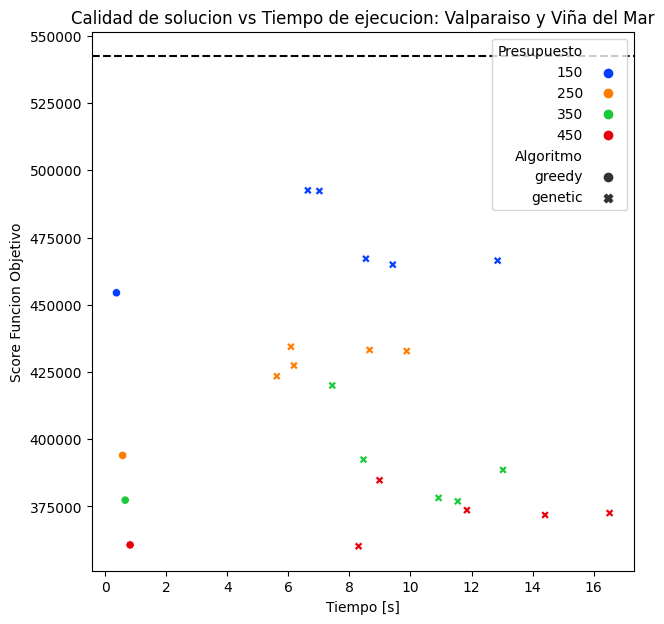

In [156]:
fig, ax = plt.subplots(figsize=(7, 7))
# ax.set(xscale="log")
c = ['b', 'orange', 'lime', 'r']
ax.axhline(sol_base, ls='--', color = 'k')
for i, score in enumerate(output[output.Algoritmo == 'pulp_solver'].Score):
    ax.axhline(score, ls='--', color = c[i])
sns.scatterplot(output[output.Algoritmo.isin(['greedy','genetic'])], x = 'Tiempo', y = 'Score',
                hue = 'Presupuesto', style = 'Algoritmo', palette = 'bright', ax = ax)
plt.legend(markerfirst = False)
plt.title('Calidad de solucion vs Tiempo de ejecucion: Valparaiso y Viña del Mar')
ax.set_ylabel('Score Funcion Objetivo')
ax.set_xlabel('Tiempo [s]')
plt.show()

### Asignacion Final

37 542443.8001221275
42 360674.60083613027
42 360188.1295430324


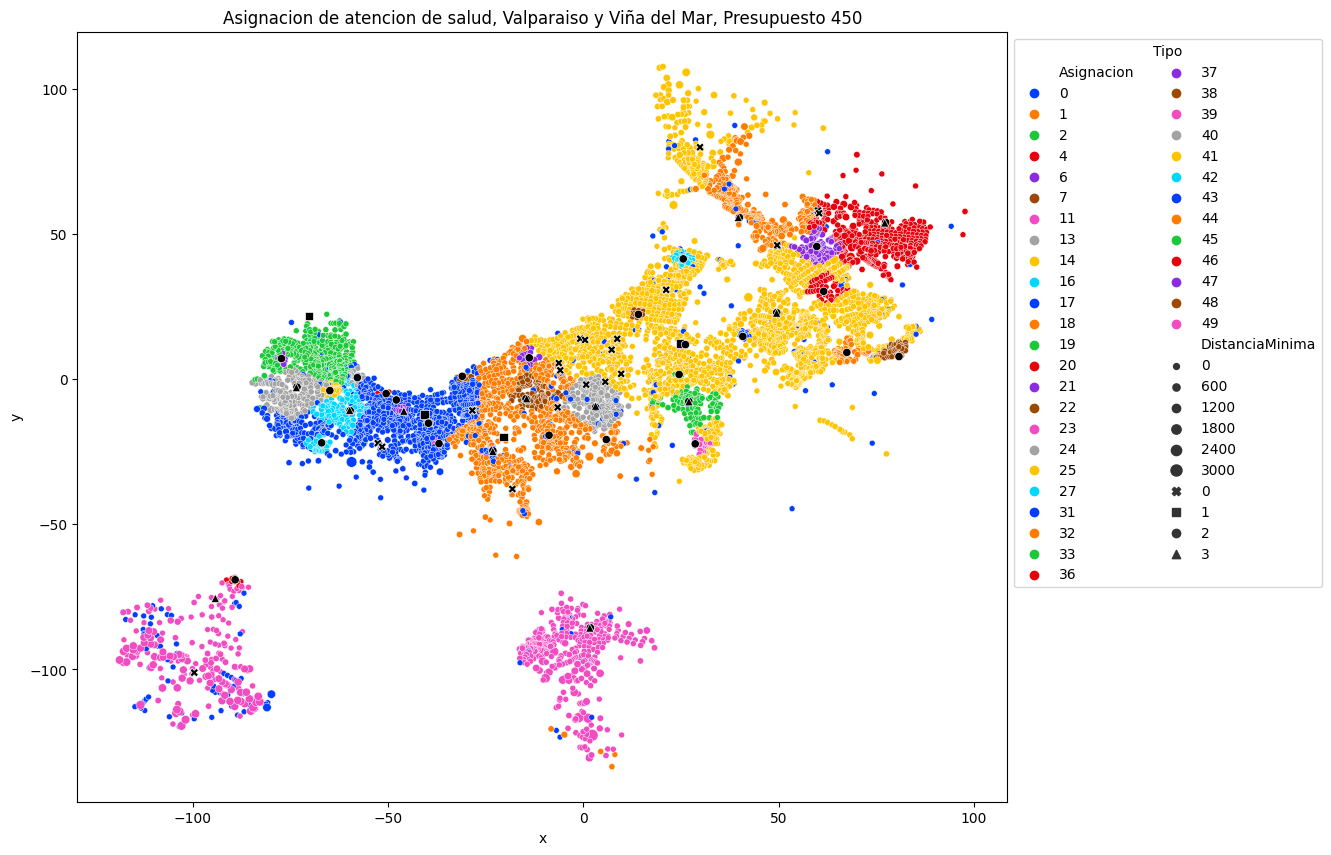

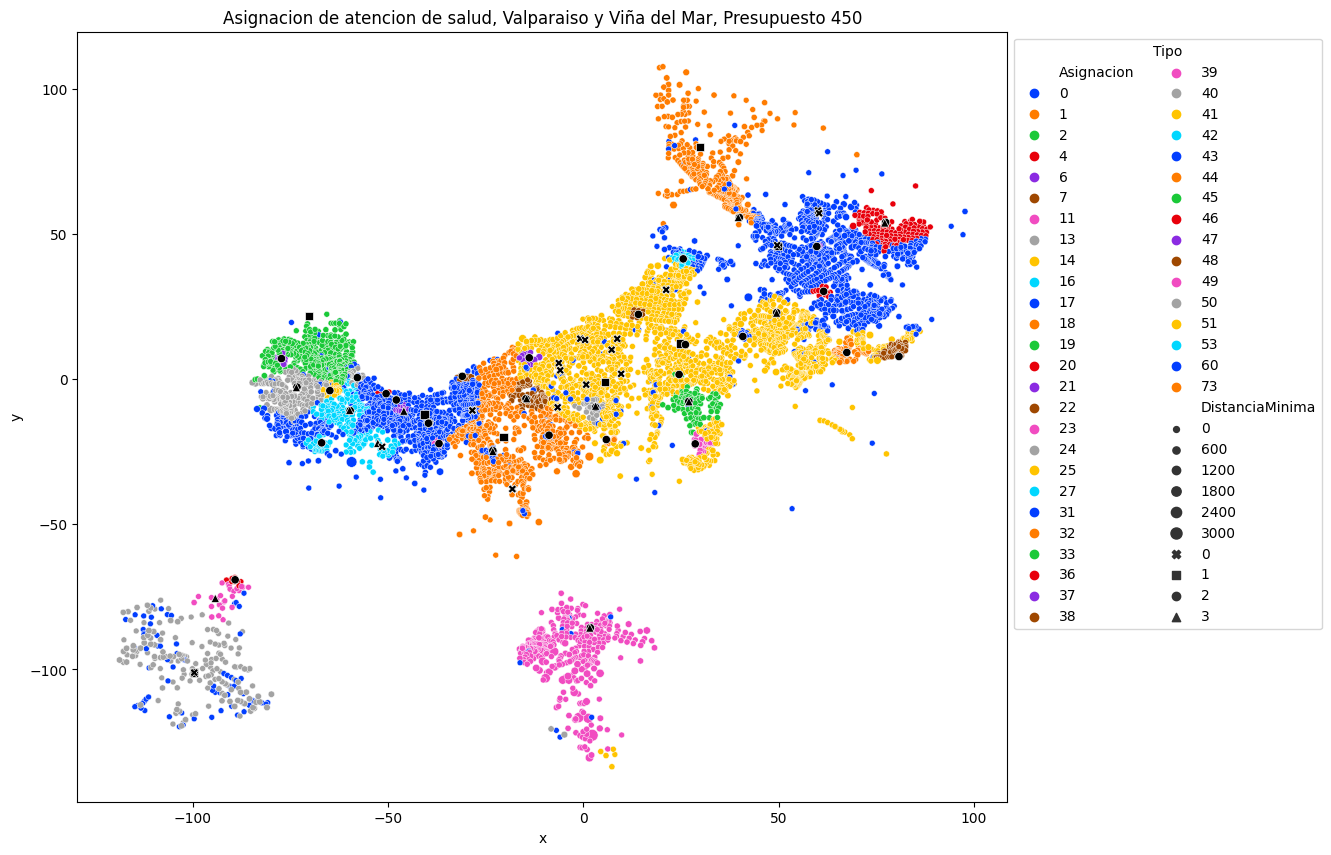

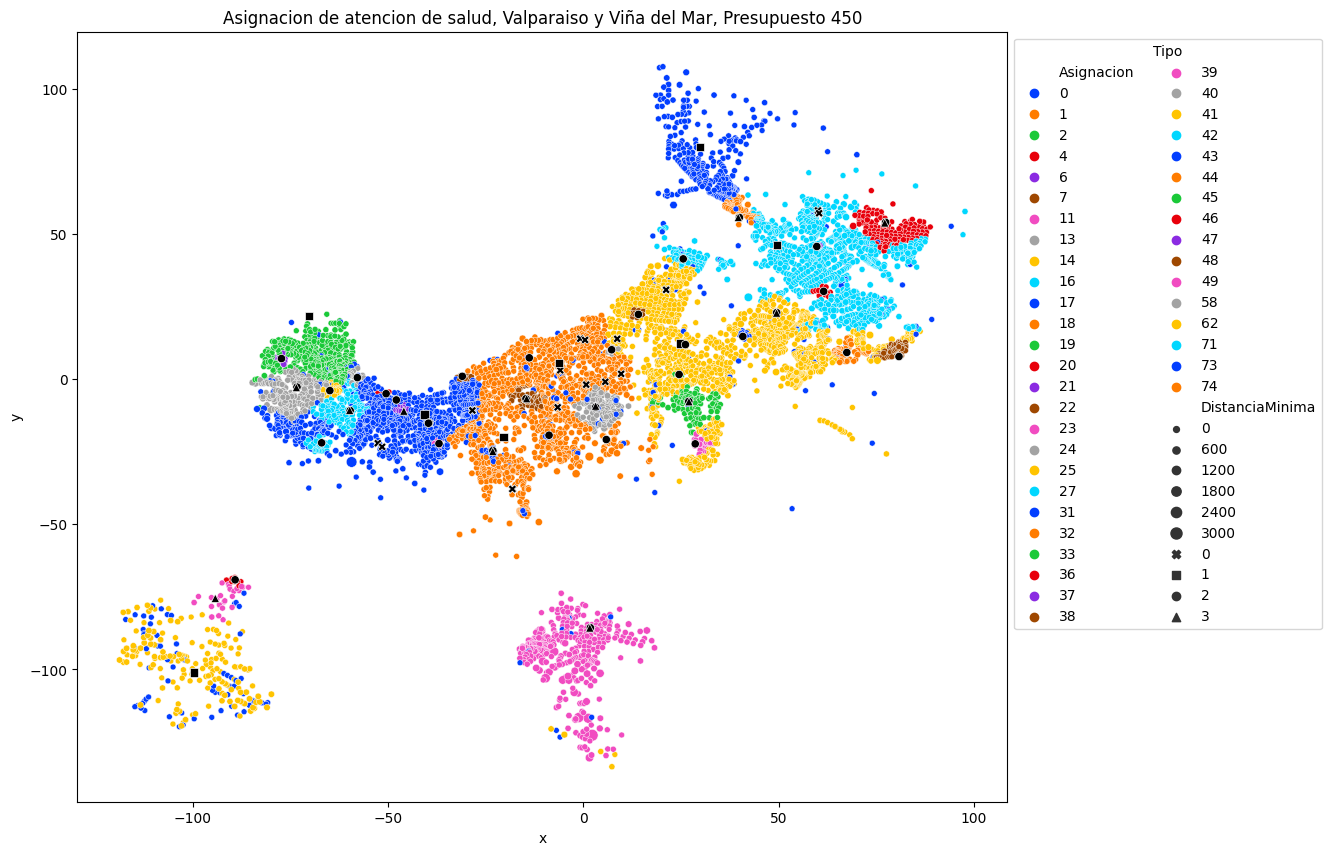

In [170]:
def asignation_plot(asig, demand_pos, supply_pos, supplys_types, min_dist):
    supply = pd.DataFrame(supply_pos, columns=['x','y'])
    supply['Tipo'] = supplys_types
    demand = pd.DataFrame(demand_pos, columns=['x','y'])
    demand['Asignacion'] = asig
    demand['DistanciaMinima'] = min_dist
    fig, ax = plt.subplots(figsize = (12,10))
    sns.scatterplot(ax = ax, data=demand, x = 'x', y = 'y', hue = 'Asignacion', size = 'DistanciaMinima', palette = 'bright')
    sns.scatterplot(ax = ax, data=supply, x = 'x', y = 'y',
                    style = 'Tipo', color = 'k', markers = ['X','s','o','^'])
    # sns.scatterplot(ax = ax, data=supply_pos)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),ncol=2)
#     plt.title('Asignacion de atencion de salud, Valparaiso y Viña del Mar, Caso Base')
    plt.title('Asignacion de atencion de salud, Valparaiso y Viña del Mar, Presupuesto 450')
    plt.plot()

pres = 450
nuevos = pd.concat([
    output[output.Presupuesto == 0],
    output[(output.Presupuesto == pres)&(output.Algoritmo == 'greedy')],
    output[(output.Presupuesto == pres)&(output.Algoritmo == 'genetic')].nsmallest(1, 'Score'),
    output[(output.Presupuesto == pres)&(output.Algoritmo == 'pulp_solver')]
])
for i in range(len(nuevos)):
    centros = nuevos.Solucion.iloc[i]
    try:res = [int(x) for x in centros.replace('.','').strip('][').split(' ')]
    except Exception as e: res = centros
    centros = np.hstack([centros_fijos,res])
    distancia_ponderada_minima = np.min(distancias * demanda[:, centros],axis = 1)
    asig, score = asignation(centros, distancias, demanda)
    asignation_plot(asig, pos_manzanas, pos_salud, centros,distancia_ponderada_minima)